
# Spotify Recomendation

This notebook is the data treatment and development of the system recomendation


In [ ]:
!pip install spotipy
!pip install pytorch_lightning
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import Dataset
import scipy.sparse as sp
import pandas as pd
import torch.nn.functional as F
import torch
torch.manual_seed(0)
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from spotipy.exceptions import SpotifyException

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 15.5 MB/s eta 0:00:00



As a future Deep Learning engineer, you will be asked to tackle some fundamental tasks. Recommendation Systems is one of these fundamental task. Obviously, you had a course introducing you to the world of recommendation. Hence, we will create a recommendation system based on Spotify Data.
<div align='center'>
<img src="https://thumbs.dreamstime.com/b/spotify-logo-mode-fonc%C3%A9-vinnytsia-ukraine-mai-service-de-musique-cool-qui-offre-la-en-streaming-l%C3%A9gale-218033923.jpg" width=400></div>

**The goal is to create a Playlist recommendation system.**


## Outline
* **Presentation of the Documentation**
* Create a functioning model
* The training
* Some tests



## Important : Set your Credentials

The credentials need to be set up so  we can use spotify client.

In [ ]:
#Set the credentials

id = # Add you id from to connect the spotify API
secret = # Add you secret identification code

# Set up Spotipy client credentials
client_credentials_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Introduction


You are working as a Data Scientist in FlexCorp, a startup that makes a Recommendation System. Obviously, as any flexible companies, an Intern was hired and did some stuff. And obviouly, there are loads of errors in it. Let's correct and give a better product.

You will be roaming around the different roles a Data Scientist can have in company. Your mission revolves around two things:
* Correct the existing works
* Fullfill the specification of the company

The company uses Pytorch-Lightning as their DL Framework

# I - Extract, Transform & Load : Being a Data Engineer and Data Analyst

Well, let's explore some data from Spotify. Obviously, we need some data.


### A - Data Engineering : Retrieving and Cleaning Data



---
Data specification:
* Retrieve Data from 1960 to 2023 in a list.

---



In [ ]:
# Retrieving the datas

query_res = [sp.search(q='year:' + str(i), type='track', limit=50) for i in range(1960, 2023)]
tracks = []
for result in query_res:
    tracks += result['tracks']['items']
print(tracks)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




---

* Retrieve the following keys is a dictionnary:
  * user_id
  * song_id
  * danceability
  * energy
  * speechiness
  * loudness
  * tempo

* Create a pandas dataframe

---

In [ ]:
track = sp.audio_features(tracks[2]['id'])[0]
track['tempo']

174.176

In [ ]:
data = []

for i in range(len(tracks)):
    track_id = tracks[i]['id']
    try:
        track = sp.audio_features(track_id)[0]
        data.append({
            'user_id': 'user_{}'.format(i % 10),
            'song_id': track_id,
            'danceability': track['danceability'],
            'energy': track['energy'],
            'speechiness': track['speechiness'],
            'loudness': track['loudness'],
            'tempo': int(track['tempo'])
        })
    except SpotifyException as e:
        # Handle 429 error (rate limit exceeded)
        print(f"Error for track {track_id}: {e}")
        # Optionally, introduce a delay before retrying
        break


# Create a pandas DataFrame from the list of data
df = pd.DataFrame(data)

# Print the first few rows of the dataset
print(df.head())



ERROR:spotipy.client:Max Retries reached


Error for track 4BggEwLhGfrbrl7JBhC8EC: http status: 429, code:-1 - /v1/audio-features/?ids=4BggEwLhGfrbrl7JBhC8EC:
 Max Retries, reason: too many 429 error responses
  user_id                 song_id  danceability  energy  speechiness  \
0  user_0  4Hhv2vrOTy89HFRcjU3QOx         0.274   0.348       0.0293   
1  user_1  0zGLlXbHlrAyBN1x6sY0rb         0.421   0.285       0.0293   
2  user_2  2IdwQxhJn9ZE4zIotcCefR         0.262   0.356       0.0303   
3  user_3  4ukUoXLuFzMixyZyabSGc4         0.508   0.287       0.0523   
4  user_4  4WUcNkpoNSKoe5MUuyzrfC         0.503   0.182       0.0323   

   loudness  tempo  
0    -8.631     87  
1    -9.430     85  
2    -8.031    174  
3   -12.472    154  
4   -16.651     63  


## B - Data Analyst : Plotting Some Stuffs to Understand the Data





### Data : Speak to Me !

So we have a dataframe, but before training any models, we need to understand the data.

Let's perform Exploratory Data Analysis
* Perform the Data Exploration

In [ ]:
# Print your dataset
print(df)

     user_id                 song_id  danceability  energy  speechiness  \
0     user_0  4Hhv2vrOTy89HFRcjU3QOx         0.274   0.348       0.0293   
1     user_1  0zGLlXbHlrAyBN1x6sY0rb         0.421   0.285       0.0293   
2     user_2  2IdwQxhJn9ZE4zIotcCefR         0.262   0.356       0.0303   
3     user_3  4ukUoXLuFzMixyZyabSGc4         0.508   0.287       0.0523   
4     user_4  4WUcNkpoNSKoe5MUuyzrfC         0.503   0.182       0.0323   
...      ...                     ...           ...     ...          ...   
1994  user_4  1Oi2zpmL81Q0yScF1zxaC0         0.845   0.576       0.1530   
1995  user_5  2zbjlcLi1VQWqDNYdhyx1l         0.733   0.395       0.0366   
1996  user_6  15MJ5NThPjj6xhPcts8MiY         0.497   0.719       0.0266   
1997  user_7  0eEXcw3JLVXcRxYrVYMy68         0.866   0.534       0.2290   
1998  user_8  1wsRitfRRtWyEapl0q22o8         0.599   0.957       0.1880   

      loudness  tempo  
0       -8.631     87  
1       -9.430     85  
2       -8.031    174  
3  

In [ ]:
# Printing the outliers.
# The dataset's extreme values are known as outliers. This indicates that the outlier data points differ significantly
# from the expected values—either being noticeably larger or smaller. Values that deviate more than three standard deviations
# from the mean in data with a normal distribution are often regarded as outliers.

print(df.describe())

       danceability       energy  speechiness     loudness        tempo
count   1999.000000  1999.000000  1999.000000  1999.000000  1999.000000
mean       0.577513     0.603331     0.059200    -9.636552   119.625313
std        0.158416     0.222500     0.061482     3.874720    28.510578
min        0.000000     0.005260     0.000000   -36.612000     0.000000
25%        0.470000     0.446500     0.031700   -11.939500    98.000000
50%        0.583000     0.620000     0.038600    -9.226000   117.000000
75%        0.689000     0.782500     0.056200    -6.861500   135.000000
max        0.965000     0.996000     0.944000    -0.140000   211.000000


In [ ]:
# Print the unique songs and users.
num_users = df['user_id'].nunique()
num_songs = df['song_id'].nunique()
print('Number of unique users:', num_users)
print('Number of unique songs:', num_songs)

Number of unique users: 10
Number of unique songs: 1999


In [ ]:
# Check for nan values
print(df.isnull().sum())

user_id         0
song_id         0
danceability    0
energy          0
speechiness     0
loudness        0
tempo           0
dtype: int64


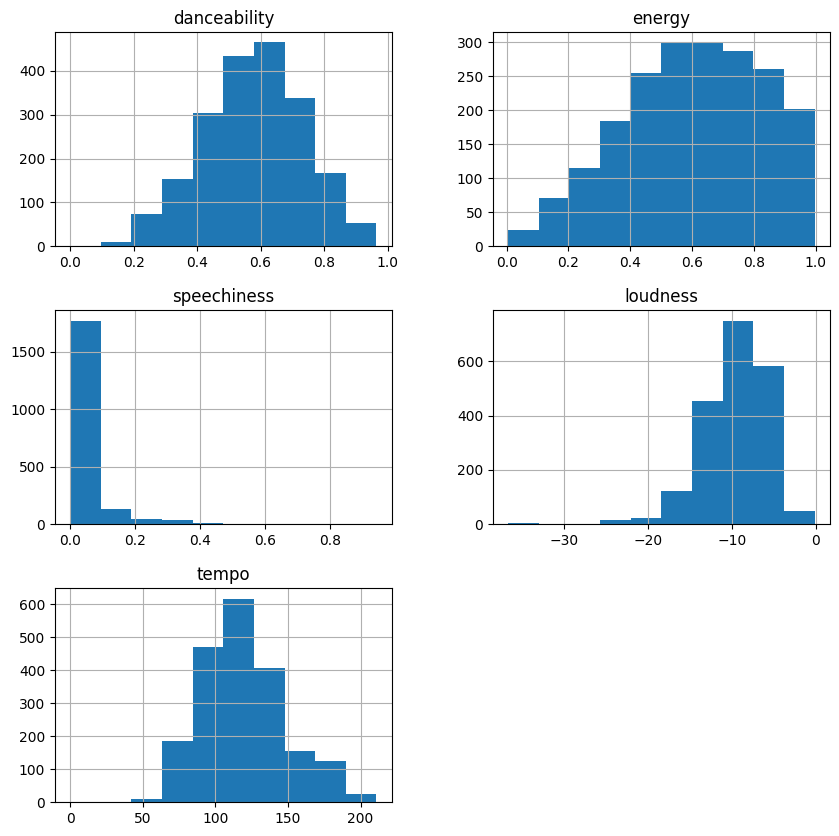

In [ ]:
# Plot the distribution of each features.
df.hist(figsize=(10,10))
plt.show()

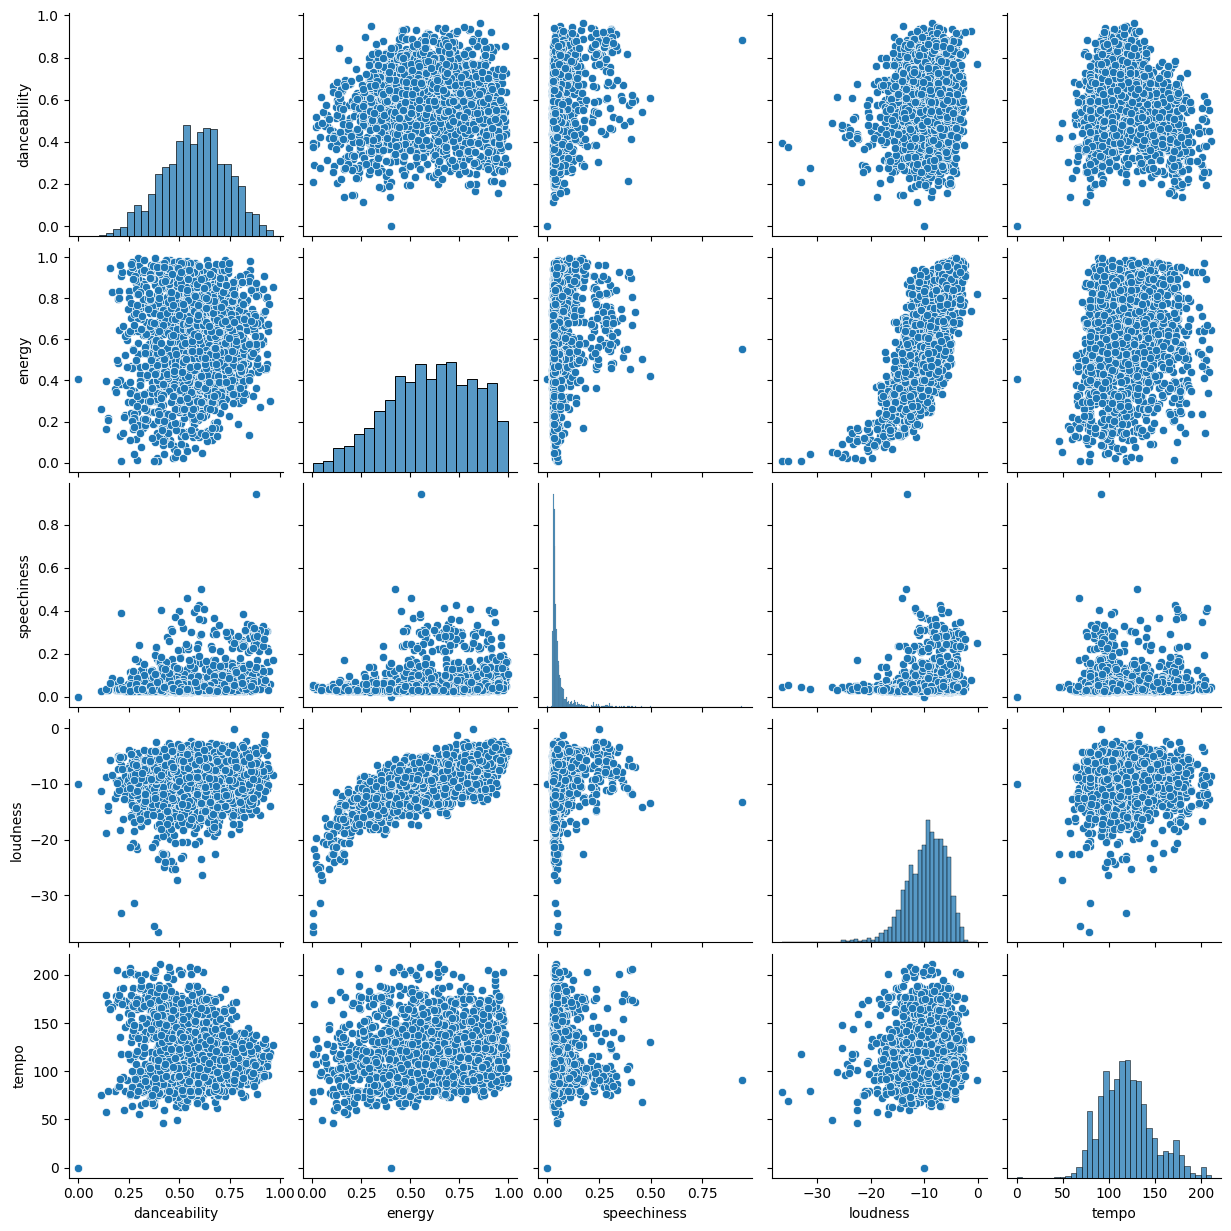

In [ ]:
# Using Seaborn plot the pairwise distributions of each features.
sns.pairplot(df.drop(['user_id', 'song_id'], axis=1))
plt.show()


<ipython-input-42-cc06e83f65a4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_songs = df.groupby('song_id').mean().sort_values('danceability', ascending=False).head(10)


                        danceability  energy  speechiness  loudness  tempo
song_id                                                                   
6jBCehpNMkwFVF3dz4nLIW         0.965   0.857       0.1700    -8.458  127.0
1tjK9HhmpEfk0ijyIKsoUk         0.952   0.301       0.0612   -13.936  119.0
3IeCYkdKI55mNMl2o4vX0k         0.946   0.772       0.1210    -7.537  116.0
6aBUnkXuCEQQHAlTokv9or         0.942   0.641       0.0333   -10.150  114.0
0Pu71wxadDlB8fJXfjIjeJ         0.939   0.675       0.2110    -7.232   96.0
5LyfiK6iXEIBNEtcaGKohl         0.935   0.479       0.3060   -10.981  123.0
7y9yjpRtZajYzVpXHRjwGz         0.935   0.805       0.2250    -4.782  105.0
57JVGBtBLCfHw2muk5416J         0.933   0.528       0.1620    -6.472  109.0
7J1uxwnxfQLu4APicE5Rnj         0.932   0.457       0.0541    -9.620  117.0
37d8O4cIq36tssCoJnhJxg         0.931   0.801       0.0548   -10.725  119.0


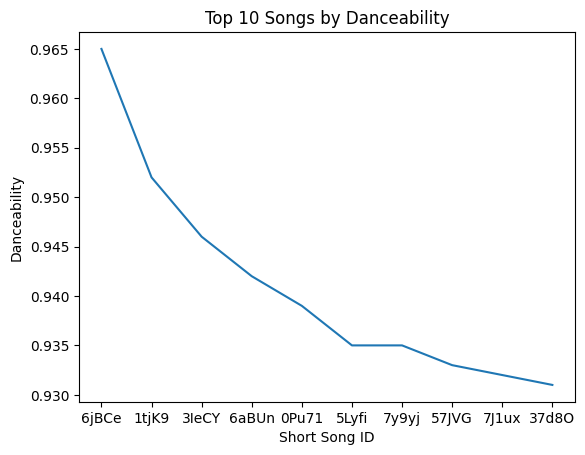

In [ ]:
# Plot the top 10 songs features sorted by their 'danceability'. Hint : GroupBy is your friend.
top_songs = df.groupby('song_id').mean().sort_values('danceability', ascending=False).head(10)
print(top_songs)

# Extract the first 5 characters from the 'song_id' column
top_songs['short_song_id'] = top_songs.index.str[:5]

# Plot only the first 5 characters of the 'song_id'
plt.plot(top_songs['short_song_id'], top_songs['danceability'])
plt.title('Top 10 Songs by Danceability')
plt.xlabel('Short Song ID')
plt.ylabel('Danceability')
plt.show()

<ipython-input-39-dbdcd60d7afb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_users = df.groupby('user_id').mean().sort_values('danceability', ascending=False).head(10)


         danceability    energy  speechiness   loudness       tempo
user_id                                                            
user_7       0.601940  0.626516     0.068532  -9.454700  122.840000
user_8       0.593245  0.592807     0.062555  -9.539645  115.205000
user_5       0.583375  0.621828     0.058049  -9.529635  116.270000
user_6       0.578730  0.564748     0.062576  -9.761250  117.325000
user_3       0.575245  0.594801     0.058086 -10.028015  120.310000
user_4       0.575050  0.611929     0.053604  -9.338755  119.625000
user_9       0.574161  0.605349     0.054577  -9.880849  122.110553
user_0       0.572855  0.590108     0.057908  -9.687650  121.320000
user_2       0.570880  0.601616     0.058342  -9.552675  119.590000
user_1       0.549630  0.623619     0.057751  -9.593565  121.670000


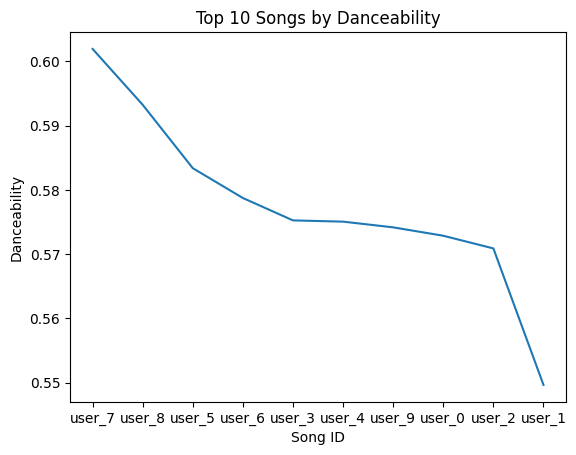

In [ ]:
#  Plot the top 10 users feautures sorted by their danceability
top_users = df.groupby('user_id').mean().sort_values('danceability', ascending=False).head(10)
print(top_users)

plt.plot(top_users['danceability'])
plt.title('Top 10 Songs by Danceability')
plt.xlabel('Song ID')
plt.ylabel('Danceability')
plt.show()


Normally, we are supposed to have a lot more understanding of the Dataset now. But there are few issues that might come from the data as is.
* What further steps do we need on the dataset ?

According to our preliminary investigation, the dataset has a few problems that need to be fixed:

Data cleaning: We must look for and deal with duplicates, outliers, and missing values in the dataset. This may entail assigning missing data, getting rid of duplicates, and using the right modifications to handle outliers.

Data normalization: In order to prevent the model from favoring certain features over others, we must normalize the data. The data may need to be scaled or standardised for this.

Feature selection: We need to select the most relevant features for the prediction task to avoid overfitting and improve model performance. Techniques like dimensionality reduction, feature importance, and correlation analysis may be used to achieve this.

Model selection and evaluation: For the prediction task, we must choose the best models, train them on the dataset, and assess their performance using the right metrics, such as accuracy, precision, recall, and F1 score. This can entail enhancing the performance of the model using strategies like cross-validation and hyperparameter tuning.

Data cleaning, normalization, feature selection, model selection, and evaluation will all be additional stages on the dataset. These procedures are essential for making sure the model is reliable and capable of making precise predictions based on new data.

### Creating a Rating

As seen before, there's no specific ratings here. We can create one based on the other features. But we need to preprocess a little bit the existing features.
* Do we need to perform preprocessing on each features ?

It is generally recommended that continuous digital features be pre-processed. In our case, the features 'danceability', 'energy', 'speechiness', 'loudness' and 'tempo' could benefit from pre-processing. The 'user_id' and 'song_id' identifiers do not require pre-processing.

* What type of preprocessing do we need to perform on the selected features ?

We can use normalisation or standardisation to bring features to the same scale. In this example, we use MinMaxScaler for normalisation, which transforms the data so that it lies within a range between 0 and 1.


* What should it change on the data ?


Data pre-processing allows features to be put on the same scale and makes it easier to compare them. It can also improve the performance of machine learning models by preventing some features from dominating others due to their scale.

In summary, data pre-processing can contribute to a better understanding of the data, make it easier to compare features and improve the performance of machine learning models.


* Using MinMaxScale, do the needed preprocessing.

More documentation on :  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Define the columns to normalize. Hint : It must be a list of strings
cols_to_normalize = ['danceability', 'energy', 'speechiness', 'loudness', 'tempo']
# Rescale and Replace the values apres preprocessing.
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


Now we can compute a rating based on other features. For the moment, we will just take in account 2 features for the computation of the rating value:   **Energy, Loudness**

* When computing the rating value, do we need to re-do some post-processing on it ?

  

In [ ]:
# Create your ratings
df['rating'] = df['energy'] * 0.5 + df['loudness'] * 0.5


In [ ]:
# Using .describe(), describe your new dataframe. What can you tell about the rating column ?
print(df.describe())

       danceability       energy  speechiness     loudness        tempo  \
count   1999.000000  1999.000000  1999.000000  1999.000000  1999.000000   
mean       0.598459     0.603661     0.062712     0.739621     0.566945   
std        0.164162     0.224579     0.065129     0.106238     0.135121   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.487047     0.445364     0.033581     0.676478     0.464455   
50%        0.604145     0.620486     0.040890     0.750877     0.554502   
75%        0.713990     0.784505     0.059534     0.815708     0.639810   
max        1.000000     1.000000     1.000000     1.000000     1.000000   

            rating  
count  1999.000000  
mean      0.671641  
std       0.156568  
min       0.000641  
25%       0.573184  
50%       0.679662  
75%       0.794103  
max       0.954247  


In [ ]:
# Calculate the mean rating for each user. Don't forget to groupby
user_ratings = df.groupby('user_id')['rating'].mean()

# Calculate the mean rating for each song
song_ratings = df.groupby('song_id')['rating'].mean()


### Data : Speak to the Computer !

We're nearly over with the Data Engineering stuff. But we need to change something crucial about the existing user/items values.

* What is the issue with the current form of the Song_id and User_id values ?

The problem with the current Song_id and User_id values is that they are strings, which is not suitable for use as input to a machine learning model. It is necessary to convert these identifiers into unique integers to facilitate their use in models.


* As seen in class, what preprocessing do we need to do on these specific columns ?

The pre-processing required for these specific columns is Label Encoding. Label encoding consists of converting each unique value into a unique integer. This makes it easier to use identifiers in machine learning models, while retaining their distinctiveness.

* Do we need to create separate pre-processors to re-encode the user and song columns ? Why ?

Yes, it is necessary to create separate preprocessors to re-encode the user and song columns. The reason for this is that each preprocessor must be specific to the column it is processing. The preprocessors must be able to handle the unique values present in each column and assign unique integers accordingly. By using separate preprocessors for each column, you ensure that they are tailored to the data they are processing and that they are able to handle unique identifiers correctly.

In [ ]:


# TODO : Print the user_id or song_id. What is the issue ?
#Nous avons l'id des song et pas les noms... c'est très problématique pour la compréhension des données
print(df[['user_id', 'song_id']].head())

  user_id                 song_id
0  user_0  4Hhv2vrOTy89HFRcjU3QOx
1  user_1  0zGLlXbHlrAyBN1x6sY0rb
2  user_2  2IdwQxhJn9ZE4zIotcCefR
3  user_3  4ukUoXLuFzMixyZyabSGc4
4  user_4  4WUcNkpoNSKoe5MUuyzrfC


In [ ]:
from sklearn.preprocessing import LabelEncoder

# TODO : Re-encode the user_id and song_id columns to the correct values.
encoder_user = LabelEncoder()
encoder_song = LabelEncoder()

df.user_id = encoder_user.fit_transform(df.user_id)
df.song_id = encoder_song.fit_transform(df.song_id)

## C - Creating the PyTorch Dataset: Being a ML/DL Ops



#### Creating the PyTorch Dataset

That was a long ride. But we are ready to train our model now. But first, let's create a Pytorch Dataset Class that we can reuse.
The PlaylistDataset class takes as input:
* df : the dataframe you've been creating from the beginning


In [ ]:
class PlaylistDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Retrieve the row corresponding to idx from the dataframe
        row = self.df.iloc[idx]
        # Retrieve these values and convert them into torch.tensor
        user = torch.tensor(row['user_id'],dtype=torch.int)
        song = torch.tensor(row['song_id'],dtype=torch.int)
        danceability = torch.tensor(row['danceability'],dtype=torch.float)
        energy = torch.tensor(row['energy'],dtype=torch.float)
        speechiness = torch.tensor(row['speechiness'],dtype=torch.float)
        loudness = torch.tensor(row['loudness'],dtype=torch.float)
        tempo = torch.tensor(row['tempo'],dtype=torch.float)
        rating = torch.tensor(row['rating'],dtype=torch.float)


        return {
            'user': user,
            'song': song,
            'danceability': danceability,
            'energy': energy,
            'speechiness': speechiness,
            'loudness': loudness,
            'tempo': tempo,
            'rating': rating
        }

In [ ]:
# Make sure that your Dataset returns what we want.
dataset = PlaylistDataset(df)
sample = dataset[0]
print(sample)
print("-----------------------------")
# Print the sample
print("user_id:", sample['user'])
print("song_id:", sample['song'])
print("danceability:", sample['danceability'])
print("energy:", sample['energy'])
print("speechiness:", sample['speechiness'])
print("loudness:", sample['loudness'])
print("tempo:", sample['tempo'])
print("rating:", sample['rating'])

{'user': tensor(0, dtype=torch.int32), 'song': tensor(1065, dtype=torch.int32), 'danceability': tensor(0.2839), 'energy': tensor(0.3459), 'speechiness': tensor(0.0310), 'loudness': tensor(0.7672), 'tempo': tensor(0.4123), 'rating': tensor(0.5566)}
-----------------------------
user_id: tensor(0, dtype=torch.int32)
song_id: tensor(1065, dtype=torch.int32)
danceability: tensor(0.2839)
energy: tensor(0.3459)
speechiness: tensor(0.0310)
loudness: tensor(0.7672)
tempo: tensor(0.4123)
rating: tensor(0.5566)


#### Creating the PyTorch Lightning Datamodule

Obviously, we can still rewrite all the code we wrote each and every time to train a model but meh, it's too much work :)

Let's use Pytorch Lightning.

* The DataModule class is a simple wrapper that encompasses all your datasets and dataloaders under one class. However, we need some proper initialization.
We need to create the Training, Validation and Testing Dataloader for each data sets we have.

* Fill in the blanks

In [ ]:
class PlaylistDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size=32, val_ratio=0.3):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.val_ratio = val_ratio

    def prepare_data(self):
        # download or preprocess data here
        pass

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            # Split dataset into train and val sets
            train_len = int((1 - self.val_ratio) * len(self.df))
            val_len = len(self.df) - train_len
            self.train_data, self.val_data = random_split(PlaylistDataset(self.df), [train_len, val_len]) # Google Random_split, and find what you have to put here
        if stage == 'test' or stage is None:
            # use entire dataset for testing
            self.test_data = PlaylistDataset(self.df)

    def train_dataloader(self):
        # Init your train_loader
        train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True,drop_last=True)
        return train_loader

    def val_dataloader(self):
        # Init your val_loader
        val_loader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False,drop_last=True)
        return val_loader

    def test_dataloader(self):
        # Init your test_loader
        test_loader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False,drop_last=True)
        return test_loader

# II - Getting Back to the NCF with Lightning : Being a Data Scientist

As seen in class, we have plenty of models available to train a RecSys model. Let's use a model everyone uses: Neural Collaborative Filtering Model.

However, comparing it to the one presented in class, the present model is a little bit more complex version that will handle more features than the basic User/Items embedding layers of the NCF.
* What are the two mains parts of the NCF model ?

The two main parts of the Neural Collaborative Filtering (NCF) model are the Generalized Factorization Matrix (GMF) and the Multilayer Perceptron (MLP). The GMF learns latent interactions between users and features, while the MLP learns non-linear interactions between latent features.


* What is the purpose of the nn.Embedding layer ?


The purpose of the nn.Embedding layer is to transform discrete identifiers (such as user and element identifiers) into continuous vectors of fixed size. These vectors are called embeddings and can be used to represent entities in a continuous vector space, making it easier to learn the relationships between them.


* What are the differences between the Embedding Layers and the Linear Layers.

The differences between embedding layers and linear layers lie in their objectives and uses. Embedding layers transform discrete identifiers into continuous vector representations, while linear layers (also known as dense layers) are used to perform linear transformations of input data by applying weights and biases.

* What basic operation do we perform to keep the informations given by all the features with User Embedding and Item Embedding ?


To keep the information given by all the features with User Embedding and Item Embedding, we generally perform a combination operation, such as concatenation, item-by-item multiplication or a linear combination of embeddings. This allows the information from the different features to be merged and the interactions between them to be learned.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class NCF(pl.LightningModule):
    def __init__(self, num_users, num_songs, embed_dim=32, hidden_dim=64, used_features=2):
        super(NCF, self).__init__()

        # User embedding layer
        self.user_embed = nn.Embedding(num_users, embed_dim)
        # Define your Song embedding layer
        self.song_embed = nn.Embedding(num_songs, embed_dim)
        # Define your MLP layers. The first layer is given
        self.layer1 = nn.Linear(embed_dim*2+used_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.layer3 = nn.Linear(hidden_dim//2, 1)

        # TODO : What's the purpose of this class attribute ?
        # purpose of this class attribute is to indicate the number of features used in the model
        self.used_features = used_features

    def forward(self, user, song,  energy, loudness,danceability= None, speechiness= None ,  tempo= None  ,  rating = None):
        # Embed user and song
        user_embed = self.user_embed(user)
        song_embed = self.song_embed(song)

        # Perform the basic operation. Don't forget to unsqueeze if shapes doesn't fit
        x = torch.cat([user_embed, song_embed, energy.unsqueeze(1), loudness.unsqueeze(1),danceability.unsqueeze(1),speechiness.unsqueeze(1),tempo.unsqueeze(1),rating.unsqueeze(1)], dim=1)


        # Pass through MLP layers
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)

        # Output final prediction
        return x.view(-1)

    def training_step(self, batch, batch_idx):
        # Retrieve the wanted characteristics from the input batch
        user = batch['user']
        song = batch['song']
        energy = batch['energy']
        loudness = batch['loudness']
        rating = batch['rating']
        tempo = batch['tempo']
        speech = batch['speechiness']
        danceability = batch['danceability']

        # Forward pass
        output = self.forward(user, song, energy, loudness,danceability,speech,tempo,rating)
        # Compute your loss
        loss = F.mse_loss(output, rating)
        # Log training loss
        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):

        # Retrieve the wanted characteristics from the input batch
        user = batch['user']
        song = batch['song']
        energy = batch['energy']
        loudness = batch['loudness']
        rating = batch['rating']
        tempo = batch['tempo']
        speech = batch['speechiness']
        danceability = batch['danceability']

        output = self.forward(user, song, energy, loudness,danceability,speech,tempo,rating)
        # Compute your loss
        loss = F.mse_loss(output, rating)
        # Log validation loss
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        print(batch)
        user = batch['user']
        song = batch['song']
        energy = batch['energy']
        loudness = batch['loudness']
        rating = batch['rating']
        tempo = batch['tempo']
        speech = batch['speechiness']
        danceability = batch['danceability']

        output = self.forward(user, song, energy, loudness,danceability,speech,tempo,rating)
        loss = F.mse_loss(output, rating)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        # Define your learning_rate
        optimizer = torch.optim.Adam(self.parameters(), lr= 0.008)
        return optimizer



### Instantiate the model

Now let's create an instance of the model and the datamodule.

In [ ]:
# Initialize model
print(num_songs, num_users)
model = NCF(num_users, num_songs, embed_dim=32, hidden_dim=64, used_features=6)

# Initialize datamodule
datamodule = PlaylistDataModule(df,batch_size=16,val_ratio=0.3)

1999 10


### Trainer : The magic of Lightning

So we have the choice to either recreate the famous training, valid and testing loop, but meh..

Lightning comes with a Trainer class that handles all the training for your.
* By reading the documentation: https://lightning.ai/docs/pytorch/stable/common/trainer.html, initiate the attributes of the class.
* Train and test the model on the dataset.

In [ ]:
# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(accelerator='gpu',
                     devices=-1,
                     max_epochs=20,
                     fast_dev_run=True,
                     limit_train_batches=0, limit_val_batches=0)

#  Train the model
datamodule.setup('fit') # Setup your datamodule to the training mode


# TRAIN
print("Train dataloader:",datamodule.train_dataloader())
train = trainer.fit(model, datamodule)
print("Train: ", train)

# Evaluate the model on the test set
datamodule.setup('test')
print("Test dataloader:", datamodule.test_dataloader())


# TEST
test = trainer.test(model, datamodule.test_dataloader())
print("Test: ", test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | user_embed | Embedding | 320   
1 | song_embed | Embedding | 64.0 K
2 | layer1     | Linear    | 4.5 K 
3 | layer2     | Linear    | 2.1 K 
4 | layer3     | Linear    | 33    
-----------------------------------------
70.9 K    Trainable params
0         Non-trainable params
70.9 K    Total params
0

Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7c2159fd5750>


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([16, 70])


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train:  None
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7c2159fd5750>


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

{'user': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5], device='cuda:0',
       dtype=torch.int32), 'song': tensor([1065,  247,  602, 1235, 1132, 1561,  264,  959,  294,  871,  755,  863,
        1089, 1757, 1027,  665], device='cuda:0', dtype=torch.int32), 'danceability': tensor([0.2839, 0.4363, 0.2715, 0.5264, 0.5212, 0.6000, 0.7813, 0.7399, 0.3575,
        0.6653, 0.7699, 0.3036, 0.5782, 0.6632, 0.1430, 0.6870],
       device='cuda:0'), 'energy': tensor([0.3459, 0.2824, 0.3540, 0.2844, 0.1784, 0.5014, 0.5397, 0.8890, 0.2501,
        0.5226, 0.8012, 0.9354, 0.2198, 0.1501, 0.3974, 0.1047],
       device='cuda:0'), 'speechiness': tensor([0.0310, 0.0310, 0.0321, 0.0554, 0.0342, 0.0543, 0.0282, 0.0587, 0.0428,
        0.1165, 0.0397, 0.0540, 0.0317, 0.0445, 0.0329, 0.0488],
       device='cuda:0'), 'loudness': tensor([0.7672, 0.7453, 0.7836, 0.6619, 0.5473, 0.7963, 0.7756, 0.7672, 0.7144,
        0.7686, 0.8540, 0.8163, 0.6649, 0.6186, 0.7638, 0.5090],
       device='cuda:0'),

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2515184283256531     │
└───────────────────────────┴───────────────────────────┘

Test:  [{'test_loss': 0.2515184283256531}]


### Test the predictions

* Create a Playlist for user 1 based on the ratings your model predicted. You can obviously retrieve the top10 songs. But how ? :)

* The playlist should return the name of the song and its rating

In [ ]:
def predict(model, user_id, song_ids, energy_tensor, loudness_tensor,danceability_tensor,speechiness_tensor,tempo_tensor,rating_tensor):
    # set model to evaluation mode
    model.eval()

    # create tensor for user ID
    user_tensor = torch.tensor([user_id], dtype=torch.long)

    predicted_ratings = []

    # iterate over song IDs
    for song_id in song_ids:
        # create tensor for song ID
        song_tensor = torch.tensor([song_id], dtype=torch.long)

        # predict rating for song
        rating = model(user_tensor, song_tensor, energy_tensor, loudness_tensor, danceability_tensor, speechiness_tensor, tempo_tensor, rating_tensor)

        # append rating to list of predicted ratings
        predicted_ratings.append(rating.item())

    return predicted_ratings


# Retrieve the TOP10 songs for user 1.
user_id = 1
user_data = df[df['user_id'] == user_id]
user_song_ids = user_data['song_id'].values
user_energy = user_data['energy'].values
user_loudness = user_data['loudness'].values
user_danceability = user_data['danceability'].values
user_speechiness = user_data['speechiness'].values
user_tempo = user_data['tempo'].values
user_rating = user_data['rating'].values

all_song_ids = df['song_id'].unique()
song_ids_to_predict = np.setdiff1d(all_song_ids, user_song_ids)

# Convert numpy arrays to tensors
user_energy_tensor = torch.tensor([user_energy.mean()], dtype=torch.float)
user_loudness_tensor = torch.tensor([user_loudness.mean()], dtype=torch.float)
user_danceability_tensor = torch.tensor([user_danceability.mean()], dtype=torch.float)
user_speechiness_tensor = torch.tensor([user_speechiness.mean()], dtype=torch.float)
user_tempo_tensor = torch.tensor([user_tempo.mean()], dtype=torch.float)
user_rating_tensor = torch.tensor([user_rating.mean()], dtype=torch.float)


predicted_ratings = predict(model, user_id, song_ids_to_predict, user_energy_tensor, user_loudness_tensor, user_danceability_tensor, user_speechiness_tensor, user_tempo_tensor, user_rating_tensor)

df_predicted = pd.DataFrame({'song_id': song_ids_to_predict, 'rating': predicted_ratings})
TOP10_songs = df_predicted.groupby('song_id').mean().sort_values(by='rating', ascending=False).head(10)


In [ ]:
print(TOP10_songs)

           rating
song_id          
1444     0.378319
68       0.321682
1067     0.319680
646      0.314008
634      0.310367
43       0.309152
1773     0.297678
64       0.295011
637      0.294194
578      0.293899
